# Agrupamiento de documentos utilizando un *embedding* generado por Transformers

En este cuaderno, vamos a generar una representación de textos (*embedding*) utilizando Transformers entrenados. Para este propósito nos valdremos de la librería `sentence_transformers`, que pertenece al framework de [Hugging Face](https://huggingface.co/models).

El esquema a desarrollar en este cuaderno es el siguiente: 
 1. Se levantará una colección de *Abstracts* de artículos relacionados con el tópico sobre celdas solares e IA. Esta colección se creó utilizando Scopus. Luego, se crearán los *embeddings* de los abstracts de la colección. La dimensionalidad del vector que representa a cada documento es de 384, utilizando *all-MiniLM-L6*, y 768, mediante *all-mpnet-base*.
 2. El siguiente paso es generar un agrupamiento de los documentos que son similares. Para este propósito, implementaremos primero una reducción de la dimensionalidad utilizando análisis de componentes principales (PCA). Con el PCA, identificaremos cierto número de componentes principales para recuperar un porcentaje de la varianza y reducir la dimensionalidad.
 3. Después, reduciremos todavía más la dimensionalidad a dos dimensiones, mediante incrustración estocástica de vecinos distribuidos en *t* (*t*-SNE, por su acrónimo en inglés), una técnica de aprendizaje no supervisado útil para visualización. Tras implementar esta técnica, los *abstracts* se representan en dos dimensiones.
 4. Con el fin de identificar los *abstracts* similiares, se implenta el algoritmo de aprendizaje no supervisado Agrupamiento espacial basda en la densidad de aplicaciones con ruido (DBSCAN, por su acrónimo en inglés).
 

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

from sentence_transformers import SentenceTransformer
from sentence_transformers import util

En la siguiente celda definimos el modelo a utilizar para generar la representación de los abstracts. 

In [2]:
model_name = "all-MiniLM-L6-v2" #"all-mpnet-base-v2" #

In [3]:
model = SentenceTransformer(model_name)

Puedes consultar la documentación de los Transformers utilizados en este cuaderno en las siguientes ligas:
 - [all-MiniLM-L6](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2)
 - [all-mpnet-base](https://huggingface.co/sentence-transformers/all-mpnet-base-v2)

In [4]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

import seaborn
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import itertools

import sklearn.decomposition
import sklearn.manifold

nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\igofo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Carga de la colección y representación de los documentos

En la siguiente celda aparecen como comentario las líneas de código que eliminan los caracteres diferentes a los alfanuméricos, así como las *stopwords*. 

In [5]:
df = pd.read_csv('./abstract_collection.csv')
for row in range(df.shape[0]):
    text = df.Abstract[row]
    #text = re.sub('[\W]+', ' ', ' '.join([w for w in text.split()]))
    #text = re.sub('[\W]+', ' ', ' '.join([w for w in text.split()if w not in stop]))
    df.at[row, "Abstract"] = text

In [6]:
df.head(5)

,Title,Abstract,kw
0,Adaptive Genetic Algorithm for Optical Metasur...,As optical metasurfaces become progressively u...,NaN
1,Identifying Pb-free perovskites for solar cell...,Recent advances in computing power have enable...,Electronic structure; Forecasting; Large datas...
2,Toward Design of Novel Materials for Organic E...,Materials for organic electronics are presentl...,Artificial intelligence; Display devices; Lear...
3,Distributed Economic Dispatch in Microgrids Ba...,Microgrids incorporated with distributed gener...,Approximation algorithms; Battery storage; Dig...
4,Solar Cell Surface Defect Detection Based on I...,A solar cell defect detection method with an i...,Clustering algorithms; Deep learning; Extracti...


En la siguiente celda se puede desplegar el *abstract* de uno de los documentos de la colección tras proporcionar el índice en la variable `text_idx`.

In [7]:
text_idx = 100
text = df.Abstract[text_idx]
print(f"Abstract: {text}")
print(f"Palabras: {len(text.split())}")

Abstract: In this paper, we address a big-data analysis method for estimating the driving range of an electric vehicle (EV), allowing drivers to overcome range anxiety. First, we present an estimating approach to project the life of battery pack for 1600 cycles (i.e., 8 years/160 000 km) based on the data collected from a cycle-life test. This approach has the merit of simplicity. In addition, it considers several critical issues that occur inside battery packs, such as the dependence of internal resistance and the state-of-health. Subsequently, we describe our work on driving pattern analysis of an EV, using a machine-learning approach, namely growing hierarchical self-organizing maps, to cluster the collected EV big data. This paper contains the analysis of energy consumption and driving range estimation for EVs, including powertrain simulation and driving behavior analysis. The experimental results, including both simulating battery degradation and analysis of driving behaviors, dem

Al ejecutar la siguiente celda se codifican los documentos proporcionados (*Abstract*). Luego, las representaciones obtenidas `embeddings` son convertidas a arrays de numpy.

In [8]:
embeddings = model.encode(df.Abstract.values, convert_to_tensor=True)

In [9]:
embeddings = embeddings.cpu().numpy()
print(f"Embeddings es un array de muestras x dimensiones:{embeddings.shape}")

Embeddings es un array de muestras x dimensiones:(2327, 384)


En la siguientes dos celdas se calcula la similud de coseno entre las representaciones de dos *abstracts*. La similitud de cosenos está contenida en la variable `cosine_scores`, que es una matriz de `(abstracts,abstracts)`. Esta matriz se grafica después ocultando los elementos por encima de la diagonal, ya que la matriz `cosine_scores` es simétrica.

In [10]:
cosine_scores = util.cos_sim(embeddings,embeddings)
cosine_scores = cosine_scores.cpu().numpy()

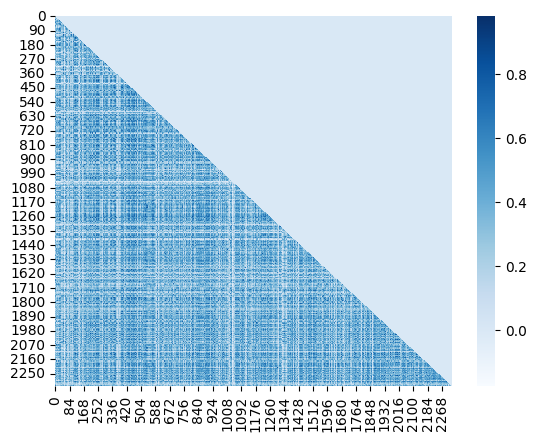

In [11]:
plt.figure()
seaborn.heatmap(np.tril(cosine_scores, k=-1), cmap='Blues')
plt.show()

Con la matriz de similitud de cosenos se podría comenzar a agrupar documentos similares definiendo un umbral de similitud o una distancia mínima entre diferentes documentos. En lo que sigue, implementaremos algunos algoritmos de aprendizaje no supervisado para visualizar el espacio definido por la colección de documentos.

### 2. Reducción de la dimensionalidad

En esta sección se implementa PCA para reducir el número de dimensiones de los documentos y visualizarlo en un espacio de dos dimensiones con componentes ortogonales. La implementación de esta sección sigue lo visto en el cuaderno de la semana 2 sobre PCA.

In [12]:
pca = sklearn.decomposition.PCA()

In [13]:
pca.fit(embeddings)

PCA()

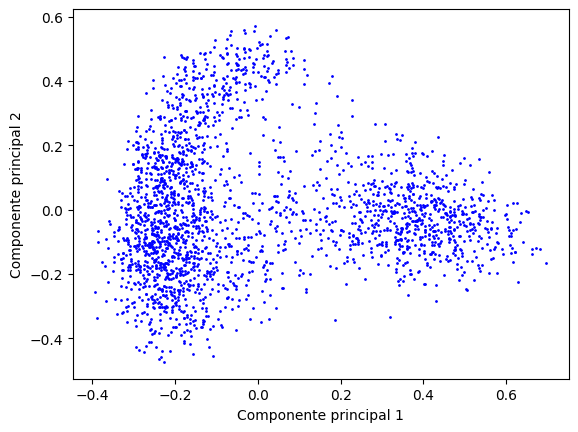

In [14]:
xpca = pca.transform(embeddings)
pca.explained_variance_ratio_.cumsum()

cp1 = 0
cp2 = 1
plt.figure()
plt.scatter(xpca[:,cp1], xpca[:,cp2], color='blue', s=1)
plt.xlabel(f'Componente principal {cp1 + 1}')
plt.ylabel(f'Componente principal {cp2 + 1}')
plt.show()

A continuación se crea `xpca` que un array que contiene la representación de cada documento en las componentes principales que recuperan el umbral de varianza definido en `varianza_umbral`.

In [15]:
varianza_umbral = 0.80
idx = (np.cumsum(pca.explained_variance_ratio_) < varianza_umbral).sum()
xpca = xpca[:, :idx]
print(f"Número de componentes principales seleccionadas:{idx}")
print(f"Dimensionalidad de xpca:{xpca.shape}")
#np.save(model_name + '_pca', xpca[:,:idx])

Número de componentes principales seleccionadas:88
Dimensionalidad de xpca:(2327, 88)


### 3. Visualización por incrustración estocástica de vecinos distribuidos en *t*

In [16]:
import sklearn.manifold
import sklearn.cluster

**t-SNE** (https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) es una técnica de reducción de la dimensionalidad para la visualización de datos en un espacio de baja dimensionalidad. El objetivo de **t-SNE** es reconstruir los datos en un espacio de dimensionalidad reducida de manera que las similitudes observadas en el espacio de alta dimensionalidad sean preservadas.

Para este propósito, se define primero una distribución de probabilidad entre pares de muestras en el espacio de alta dimensión, de manera que los pares de muestras que son similares se les asigna una probilidad alta, mientras que a las muestras poco similares se les asigna una probabilidad baja. Luego, se construye una distribución de probabilidad de las mismas muestras en un espacio de menor dimensión, y que se basa en la *t* de Student. Esta reconstrucción de la distribución se implementa de manera que la divergencia Kullback-Leibler entre las distribuciones sea mínima.

*t*-SNE se puede implementar utilizando [scikit-learn.manifold](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). Algunos hiperparámetros importantes a considerar son:
- `perplexity`: Este hiperparámetro está relacionado con el número de vecinos cercanos a una muestra en el espacio hiperdimensional. Se aconseja seleccionar valores entre 5 y 50. Este hiperparámetro no debe ser menor al número de muestras de la colección. Por defecto, es 30.0
- `early_exaggeration`: Controla la compactación de los cúmulos originales en el espacio de dimensionalidad reducida. Por defecto, este valor es 12. Valores grandes ocasionan que la distancia entre cúmulos sea grande en el espacio reducido.

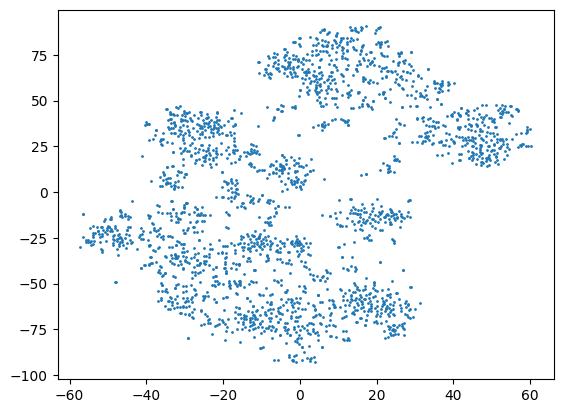

In [17]:
tsne = sklearn.manifold.TSNE(perplexity=20, early_exaggeration=80, metric='cosine', max_iter=3000)
xtsne = tsne.fit_transform(xpca)

plt.figure()
plt.scatter(xtsne[:,0], xtsne[:,1], s=1)
plt.show() 

### 4. Formación de cúmulos mediante DBSCAN

[DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) es el acrónimo es inglés de *agrupamiento espacial basda en la densidad de aplicaciones con ruido*. Este es un método de aprendizaje no supervisado no paramétrico cuyo propósito es el agrupamiento de datos. Este método se basa en el número de vecinos mínimos `min_samples` dentro de un radio definido $\epsilon$, `eps`. Este algoritmo se encuentra dentro de [sklearn.cluster ](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

En la siguiente celda se implementa DBSCAN a partir de un radio `eps` y un número mínimo de muestras `min_samples`. Luego, se grafican los cúmulos encontrados en el espacio bidimensional encontrado mediante *t*-SNE. Por fines de visualización, sólo se muestran aquellos cúmulos con un número de muestras mayor a 50.

34


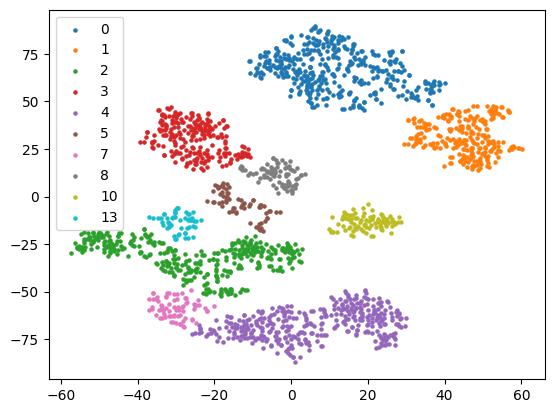

In [18]:
dbscan = sklearn.cluster.DBSCAN(eps = 3., min_samples = 5)
dbscan.fit(xtsne)

print(len(np.unique(dbscan.labels_)))
plt.figure()
for label in np.unique(dbscan.labels_):
    if label != -1:
        idx = np.argwhere(dbscan.labels_ == label)[:,0]
        
        if idx.shape[0] >= 50:
            plt.scatter(xtsne[idx, 0], xtsne[idx, 1], s=5, label = str(label))
plt.legend(loc='best')

plt.show()

In [19]:
df['dbscan'] = dbscan.labels_

#### Comparación con *k*-Means

Algunas diferencias de *k*-Means con DBSCAN son:
- *k*-Means se basa en centroides. DBSCAN se basa en la densidad de muestras.
- El número de cúmulos a formar en *k*-Mean es un hiperparámetro. En DBSCAN, los cúmulos son encontrados mediante la definición de un número mínimo de muestras y un radio.
- DBSCAN pueden identificar muestras anómalas (muestras no asignadas a un cúmulo).
- DBSCAN puede encontrar cúmulos irregulares, de diferentes tamaños y densidad. *k*-means tiende a crear cúmulos de tamaño similar.

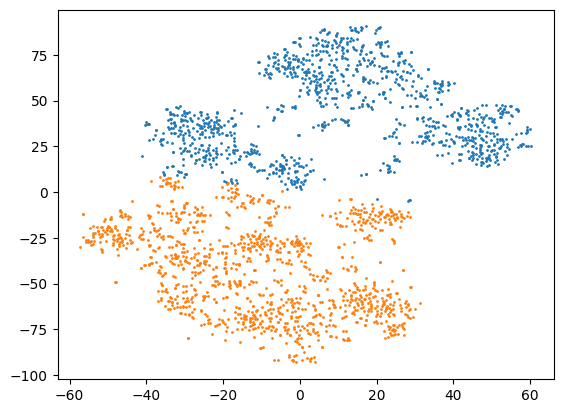

In [20]:
inertias = list()
n = 2

clustering = sklearn.cluster.KMeans(n_clusters = n)
clustering.fit(xtsne)
labels = clustering.labels_
inertias += [clustering.inertia_]

plt.figure()

for label in np.unique(labels):
    idx = np.argwhere(labels == label)[:,0]

    plt.scatter(xtsne[idx,0], xtsne[idx,1], s=1)
plt.show()    

### 5. Despliegue de nubes de palabras

In [21]:
from wordcloud import WordCloud
import collections

En esta última sección se desplegarán las gráficas de nubes de palabras. Estas nubes de palabras se basan en la columna de palabras clave de la colección `df` para cada cúmulo encontrado mediante DBSCAN.

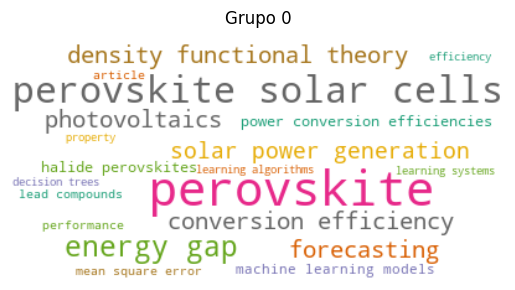

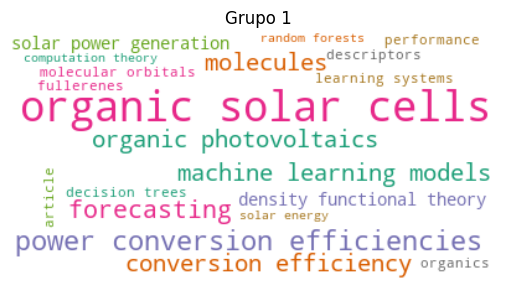

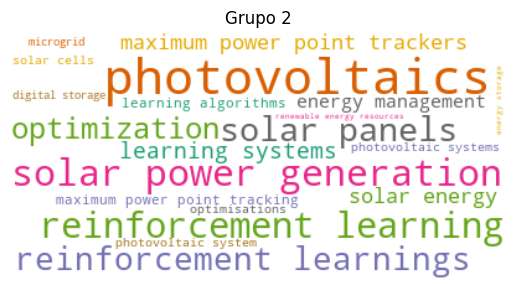

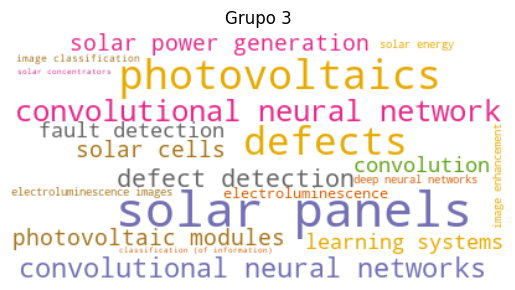

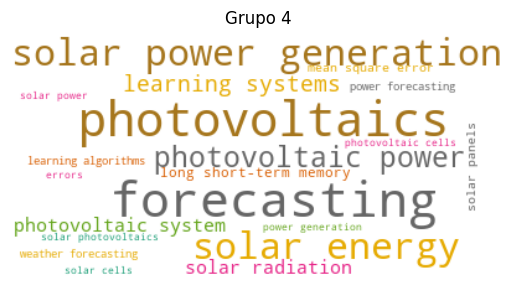

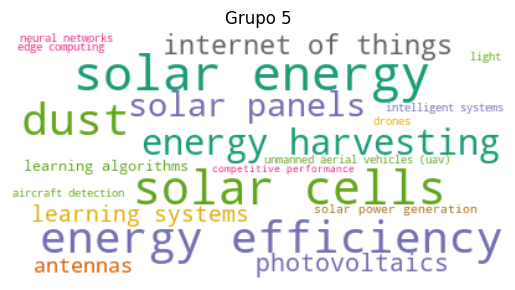

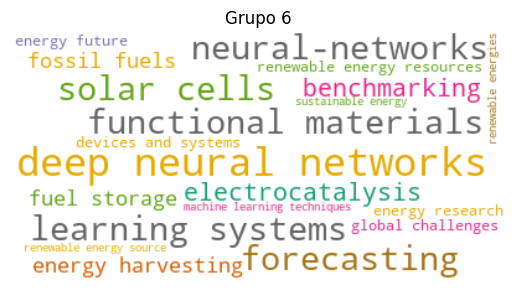

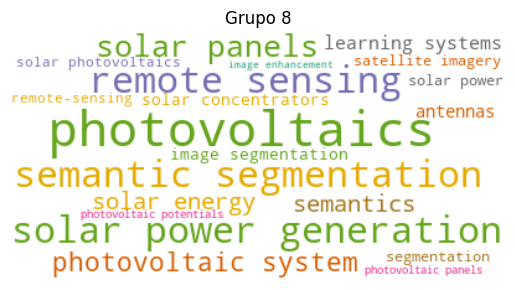

In [22]:
df = df.dropna().reset_index(drop=True)

for row in range(df.shape[0]):
    df.at[row,"kw"] = df.kw[row].strip().lower()

for label in [0,1,2,3,4,5,6,8]:
    text = list()
    for keyword_string in df[df['dbscan'] == label]['kw'].values:
        for word in keyword_string.split(';'):
            toappend = word.strip() 
            if toappend not in ['deep learning', 'machine learning', 'machine-learning', 'artificial intelligence']:
                text.append(toappend)
    
    dictionary = collections.Counter(text)
    
    cloud = WordCloud(max_font_size=40, colormap='Dark2', background_color='white', max_words=20).generate_from_frequencies(dictionary)
    plt.title(f"Grupo {label}")
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    #plt.savefig('cloudWords_' + str(label) + '.png', transparent=True)
    plt.show()

**Material para consulta posterior:** https://www.coursera.org/projects/open-source-models-with-hugging-face